# Uplift-modelling

In [56]:
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_x5
import pandas as pd
import matplotlib.pyplot as plt

# 1. Working with data

## 1.1. Loading data

We are going to work with X5 dataset.

In [3]:
dataset = fetch_x5()

Part 1: X5 train: 100%|██████████| 1.18M/1.18M [00:00<00:00, 2.10MiB/s]
Part 2: X5 clients: 100%|██████████| 7.64M/7.64M [00:04<00:00, 1.66MiB/s]
Part 3: X5 purchases: 100%|██████████| 670M/670M [07:59<00:00, 1.40MiB/s] 


## 1.2. Understanding content of data

In [26]:
dataset.feature_names

{'train_features': ['client_id', 'treatment_flg', 'target'],
 'clients_features': ['client_id',
  'first_issue_date',
  'first_redeem_date',
  'age',
  'gender'],
 'purchases_features': ['client_id',
  'transaction_id',
  'transaction_datetime',
  'regular_points_received',
  'express_points_received',
  'regular_points_spent',
  'express_points_spent',
  'purchase_sum',
  'store_id',
  'product_id',
  'product_quantity',
  'trn_sum_from_iss',
  'trn_sum_from_red']}

`train features`:
- `client_id` - client ID
- `treatment_flg` - treatment flag: 
    - `0` - no communication, 
    - `1` - with communication
- `target` - flag of target action: 
    - `0` - no action, 
    - `1` - action

`clients_features`:
- `client_id` - client ID
- `first_issue_date` - date of first card release
- `first_redeem_date` - date of first payment
- `age` - age
- `gender` - gender:
    - `F` - female
    - `M` - male
    - `U` - unknown

`purchases_features`:
- `client_id` - client ID
- `transaction_id` - transaction ID
- `regular_points_received` 
- `express_points_received`
- `regular_points_spent`
- `express_points_spent`
- `purchase_sum` - total sum of transaction
- `store_id` - store ID
- `product_id` - product ID
- `product_quantity` - quantity of product ID
- `trn_sum_from_iss` 
- `trn_sum_from_red` 

## 1.3. Feature selecting

- `client_id`
- `first_issue_time` - convert `first_issue_date` from datetime type to int: number of days past `2017-01-01 00:00:00`
- `first_redeem_time` - convert `first_redeem_date` from datetime type to int: number of days past `2017-01-01 00:00:00`
- `age`
- `gender` - "one-hot" representation

## 1.4. Feature generation
- `transaction_amount` - total number of transactions
- `transaction_sum` - total sum of transactions
- `regular_points_spent_sum` - total sum of `regular_points_spent`
- `express_points_spent_sum` - total sum of `express_points_spent`
- `ragular_points_spent_to_total` - `regular_points_spent` / `transaction_sum`
- `express_points_spent_to_total` - `express_points_spent` / `transaction_sum`
- `avg_transaction` - `transaction_sum` / `transaction_amount`

In [96]:
df_clients = dataset.data['clients'].set_index("client_id")
df_purchases =  pd.concat([dataset.data['purchases'][["client_id", "transaction_id"]].drop_duplicates().groupby(["client_id"]).count(),
                           dataset.data['purchases'][["client_id", "purchase_sum", "regular_points_spent", "express_points_spent"]].drop_duplicates().groupby(["client_id"]).sum()], 
                           axis=1)
df_train = pd.concat([dataset.data['train'], dataset.treatment , dataset.target], axis=1).set_index("client_id")
indices_test = pd.Index(set(df_clients.index) - set(df_train.index))

df_features = df_clients.copy()

df_features['first_issue_time'] = \
    ((pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('2017-01-01')) // pd.Timedelta('1d'))
    
df_features['first_redeem_time'] = \
    ((pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('2017-01-01')) // pd.Timedelta('1d'))
    
df_features['gender_M_flg'] = pd.get_dummies(df_features['gender'])['M']
df_features['gender_F_flg'] = pd.get_dummies(df_features['gender'])['F']

df_features['transaction_amount'] = df_purchases['transaction_id']
df_features['transaction_sum'] = df_purchases['purchase_sum']
df_features['regular_points_spent_sum'] = -df_purchases['regular_points_spent']
df_features['express_points_spent_sum'] = -df_purchases['express_points_spent']

df_features['ragular_points_spent_to_total'] = df_features['regular_points_spent_sum'] / df_features['transaction_sum']
df_features['express_points_spent_to_total'] = df_features['express_points_spent_sum'] / df_features['transaction_sum']
df_features['avg_transaction'] = df_features['transaction_sum']/df_features['transaction_amount']

df_features = df_features.drop(['first_issue_date', 'first_redeem_date', 'gender'], axis=1)

indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=42)

del df_clients
del df_purchases

pd.concat([df_features.head(), df_features.tail()], axis=0)

,age,first_issue_time,first_redeem_time,gender_M_flg,gender_F_flg,transaction_amount,transaction_sum,regular_points_spent_sum,express_points_spent_sum,ragular_points_spent_to_total,express_points_spent_to_total,avg_transaction
client_id,,,,,,,,,,,,
000012768d,45,216,368.0,0,0,4,2803.00,-0.0,-0.0,-0.000000,-0.0,700.750000
000036f903,72,99,112.0,0,1,32,9439.00,-0.0,-0.0,-0.000000,-0.0,294.968750
000048b7a6,68,713,NaN,0,1,8,3772.00,-0.0,-0.0,-0.000000,-0.0,471.500000
000073194a,60,142,327.0,0,1,17,9282.40,96.0,-0.0,0.010342,-0.0,546.023529
00007c7133,67,141,729.0,0,0,11,6719.84,240.0,-0.0,0.035715,-0.0,610.894545
fffece623e,67,497,725.0,0,0,24,6530.01,68.0,-0.0,0.010413,-0.0,272.083750
ffff3dfff8,56,669,705.0,0,1,17,7264.84,182.0,-0.0,0.025052,-0.0,427.343529
ffffaab9da,23,236,341.0,0,1,7,3791.00,6.0,-0.0,0.001583,-0.0,541.571429
ffffeb5619,62,338,NaN,0,0,7,15226.22,-0.0,-0.0,-0.000000,-0.0,2175.174286


In [91]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[df_train.index, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

del df_train

## 1.5. Ideas!!!

### 1.5.1 Use some products as features (I don't know is it a good idea)

I guess `4009f09b04` is a plastic bag :)

In [93]:
dataset.data.purchases.product_id.value_counts().head(15)

4009f09b04    1824586
15ccaa8685     628910
bf07df54e1     414745
3e038662c0     383480
4dcf79043e     370451
f4599ca21a     330278
5cb93c9bc5     320701
4a29330c8d     293404
439498bce2     251743
343e841aaa     230927
0a46068efc     221386
dc2001d036     206469
31dcf71bbd     191268
5645789fdf     188635
113e3ace79     188625
Name: product_id, dtype: int64

<AxesSubplot: >

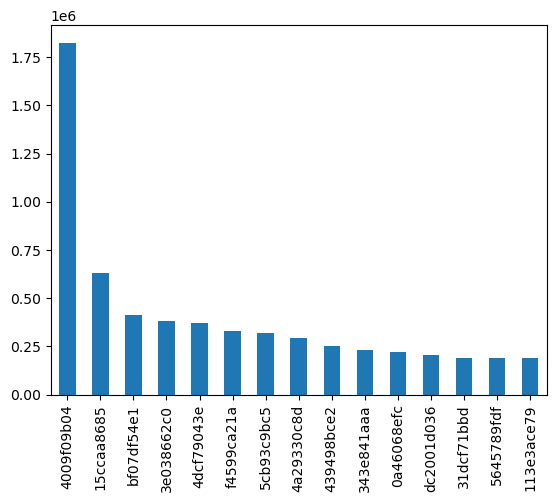

In [62]:
dataset.data.purchases.product_id.value_counts().head(15).plot.bar()

# 2. Trying some models

In [97]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

## 2.1. S-Learner (Solo model approach)

<p align="center" width="500">
    <img src="SoloModel.png" alt="Solo Model" width="500"/>
</p>

/Users/parutin/miniconda3/envs/ml_env/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/parutin/miniconda3/envs/ml_env/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


array([<AxesSubplot: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot: title={'center': 'Control predictions'}>,
       <AxesSubplot: title={'center': 'Uplift predictions'}>],
      dtype=object)

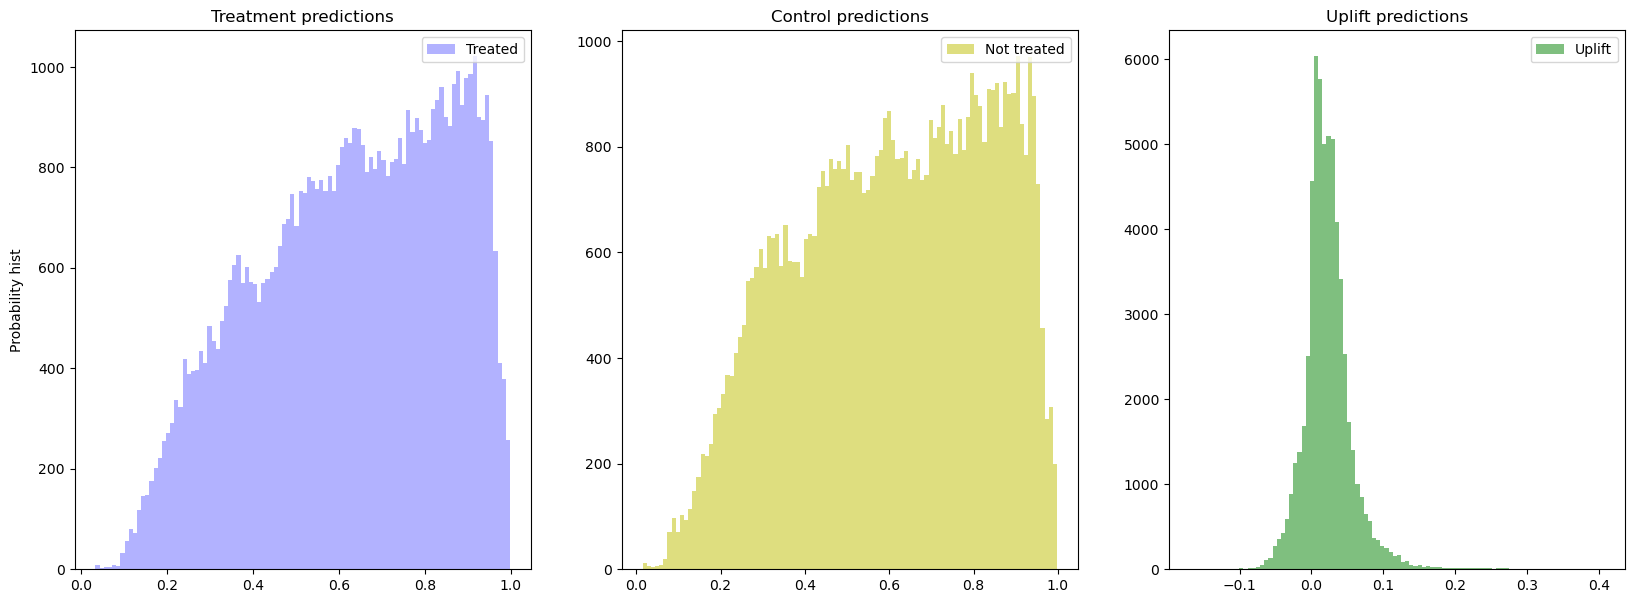

In [109]:
from sklift.models import SoloModel

from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(iterations=100, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [110]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,transaction_amount,38.374420
1,first_redeem_time,29.168489
2,first_issue_time,9.229916
3,age,5.256794
4,transaction_sum,4.994304
5,avg_transaction,3.944639
6,regular_points_spent_sum,3.063024
7,ratio_spent_points_to_total,2.648195
8,treatment,2.180433
9,gender_M_flg,0.635082


## 2.2. Class Transformation approaсh

In [112]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=100, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

/Users/parutin/miniconda3/envs/ml_env/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


,feature_name,feature_score
0,first_redeem_time,34.341833
1,first_issue_time,11.799827
2,age,11.020110
3,transaction_sum,10.071120
4,avg_transaction,9.416175
5,ratio_spent_points_to_total,7.231628
6,transaction_amount,7.119674
7,regular_points_spent_sum,5.807981
8,gender_M_flg,1.717150
9,gender_F_flg,1.474504
